NSL-KDD Multi-class

#Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data

In [3]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','class','difficulty_level']

In [4]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain+.txt", names = features)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest+.txt", names = features)

print(train_df.shape)
print(test_df.shape)


Mounted at /content/drive
(125967, 43)
(22549, 43)


In [5]:
#combining train and test files (there's an error when doing the one hot encoding)
data = pd.concat([train_df, test_df])
print(data.shape)
data.head()

(148516, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [6]:
data.info()
""" 
  'protocol_type','srevice', 'flag' : categorical types
  'difficulty_level'                : usless
  'class'                           : has multiplie classes of attaks and a normal class
  
  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148516 entries, 0 to 22548
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148516 non-null  int64  
 1   protocol_type                148516 non-null  object 
 2   service                      148516 non-null  object 
 3   flag                         148516 non-null  object 
 4   src_bytes                    148516 non-null  int64  
 5   dst_bytes                    148516 non-null  int64  
 6   land                         148516 non-null  int64  
 7   wrong_fragment               148516 non-null  int64  
 8   urgent                       148516 non-null  int64  
 9   hot                          148516 non-null  int64  
 10  num_failed_logins            148516 non-null  int64  
 11  logged_in                    148516 non-null  int64  
 12  num_compromised              148516 non-null  int64  
 13  

" \n  'protocol_type','srevice', 'flag' : categorical types\n  'difficulty_level'                : usless\n  'class'                           : has multiplie classes of attaks and a normal class\n  \n  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing\n"

In [7]:
#some stats
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,276.781168,40228.220165,17088.968657,0.000215,0.020523,0.000202,0.189380,0.004323,0.402792,0.255063,0.001508,0.000976,0.273728,0.012073,0.000525,0.004013,0.000000,0.000081,0.012308,83.333695,28.252121,0.256926,0.255339,0.137942,0.138481,0.672987,0.067755,0.097442,183.927563,119.463458,0.534524,0.084097,0.145933,0.030584,0.256123,0.251306,0.136215,0.136391,19.278495
std,2460.691310,5409629.816013,3703537.248657,0.014677,0.240070,0.019417,2.013167,0.072248,0.490461,22.231450,0.038807,0.042389,22.689100,0.517865,0.027701,0.095257,0.000000,0.008989,0.110259,116.755909,75.369855,0.431919,0.432579,0.339382,0.341777,0.436542,0.194651,0.258886,98.528487,111.232267,0.448061,0.194088,0.308638,0.108975,0.428501,0.429720,0.322736,0.335276,2.739760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,278.000000,571.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000,21.000000
max,57715.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,100.000000,5.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


### fixing labels

In [8]:
#Actual labels
print(data['class'].value_counts())

normal             77054
neptune            45871
satan               4367
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [9]:
#fixing labels

dos_class =["apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm"]
R2L_class =["ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop"]      
Probe_class =["ipsweep","mscan","nmap","portsweep","saint","satan"]
U2R_class =["buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm"]

for atk in dos_class:
  data.loc[data['class'] == atk, 'class'] = 'DoS'
for atk in R2L_class: 
  data.loc[data['class'] == atk, 'class'] = 'R2L'
for atk in Probe_class: 
  data.loc[data['class'] == atk, 'class'] = 'Probe'
for atk in U2R_class :
  data.loc[data['class'] == atk, 'class'] = "U2R"

data['class'].value_counts()


normal    77054
DoS       53387
Probe     14076
R2L        3880
U2R         119
Name: class, dtype: int64

##Data visualisation

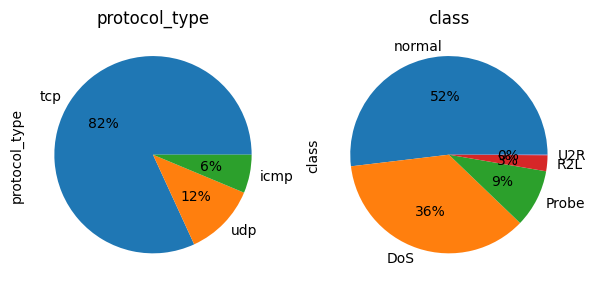

In [10]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(7, 7), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(data, ['protocol_type', 'class'], 1, 2)

# prétraitement



##### 1-Normalisation (Robuste)

In [11]:
#les colonnes doivent etre numeriques seulement
def normalisation(dataframe, columns):
  normalised_df = pd.DataFrame(RobustScaler().fit_transform(dataframe), columns = columns)
  return normalised_df
  

In [12]:
categorical_columns = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'difficulty_level', 'class']

In [13]:

def preprocessing(dataframe):
  #selectionner le valeurs numeriques puis les normaliser
  num_df = dataframe.drop(categorical_columns, axis=1)
  num_cols = num_df.columns
  normalized_df = normalisation(num_df, num_cols)


  #supression des ancienne données numeriques et rajout des données normalisées
  dataframe.drop(labels = num_cols, axis= 'columns', inplace = True)
  dataframe[num_cols] = normalized_df[num_cols]

  #remplaces les lables de la colonne 'class": 
  #0 => normal
  #1 => Dos
  #2 => Probe
  #3 => R2L
  #4 => U2R
  dataframe.loc[dataframe['class'] == "normal", "class"]= 0
  dataframe.loc[dataframe['class'] == "DoS", "class"]= 1
  dataframe.loc[dataframe['class'] == "Probe", "class"]= 2
  dataframe.loc[dataframe['class'] == "R2L", "class"]= 3
  dataframe.loc[dataframe['class'] == "U2R", "class"]= 4 

  #onehot encoding
  dataframe = pd.get_dummies(dataframe, columns = ['protocol_type','service', 'flag'])

  return dataframe

In [85]:
normalized_df = preprocessing(data)
normalized_df

,land,logged_in,is_host_login,is_guest_login,class,difficulty_level,duration,src_bytes,dst_bytes,wrong_fragment,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,20,0.0,1.619565,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,15,0.0,0.369565,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,19,0.0,-0.159420,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,21,0.0,0.681159,15.678846,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,21,0.0,0.561594,0.807692,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22544,0,0,0,0,0,20,0.0,1.010870,1.155769,0.0,...,0,0,0,0,0,0,0,0,1,0
22545,0,0,0,0,0,21,0.0,1.065217,0.753846,0.0,...,0,0,0,0,0,0,0,0,1,0
22546,0,0,0,0,2,17,0.0,-0.159420,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
22547,0,0,0,0,2,17,0.0,0.876812,1.759615,0.0,...,1,0,0,0,0,0,0,0,0,0


#####Data augmentation

<Axes: >

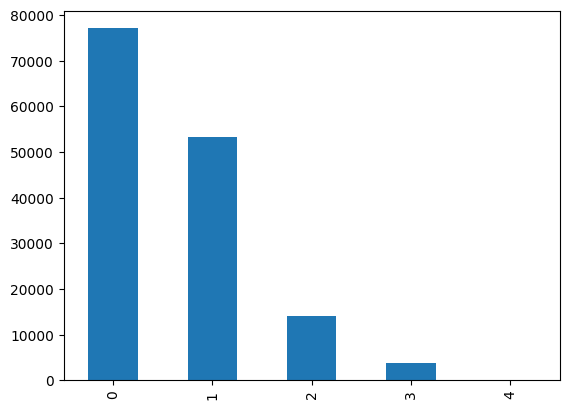

In [86]:
#code to augment some classes
normalized_df['class'].value_counts()
normalized_df['class'].value_counts().plot(kind = "bar")

In [87]:
minority_classes = [ 2 , 3 , 4]
mask = normalized_df['class'].isin(minority_classes)
minority_df = normalized_df[mask]
minority_df

,land,logged_in,is_host_login,is_guest_login,class,difficulty_level,duration,src_bytes,dst_bytes,wrong_fragment,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
13,0,1,0,0,3,15,0.0,1.050725,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
17,0,0,0,0,2,18,0.0,-0.094203,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
30,0,0,0,0,2,17,0.0,-0.130435,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
33,0,0,0,0,2,20,0.0,-0.159420,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0
48,0,1,0,0,3,12,0.0,1.050725,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22524,0,1,0,0,4,4,0.0,0.644928,1.178846,0.0,...,0,0,0,0,0,0,0,0,1,0
22543,0,0,0,0,2,14,0.0,3.579710,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0
22546,0,0,0,0,2,17,0.0,-0.159420,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
22547,0,0,0,0,2,17,0.0,0.876812,1.759615,0.0,...,1,0,0,0,0,0,0,0,0,0


In [88]:
#code--
from imblearn.over_sampling import SMOTE

minority = minority_df.drop(['difficulty_level'], axis = 1)
xm = minority.drop(['class'], axis = 1)
ym = minority['class']

smote = SMOTE()
augmented_x, augmented_y = smote.fit_resample(xm.values,ym.values.astype('int'))


<Axes: >

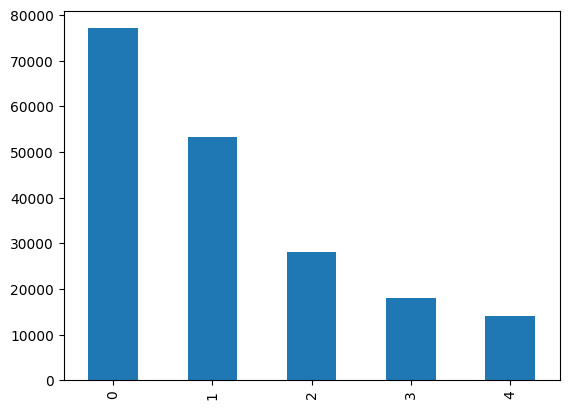

In [89]:
original_df = normalized_df
xmc = pd.DataFrame(xm).columns
ymc = pd.DataFrame(ym).columns
augmented = pd.concat([pd.DataFrame(augmented_x, columns=xmc), pd.DataFrame(augmented_y, columns = ymc)], axis = 1)
normalized_df = pd.concat([pd.DataFrame(normalized_df.drop(['difficulty_level'], axis = 1)), augmented])
#normalized_df['class'].value_counts().plot(kind = "bar")
normalized_df['class'].value_counts().plot(kind = "bar")


##### Feature selection (reduction) PCA

In [90]:
#Extraction des X et Y
x = normalized_df.drop(['class'], axis = 1).values
y = normalized_df['class'].values.astype('int')
#y_reg = normalized_df['difficulty_level'].values

#initialisation PCA
pca = PCA(n_components = 61)
pca = pca.fit(x)
x_r = pca.transform(x)

print("# Of original features: ", x.shape[1])
print("# Features after reduction: ", x_r.shape[1])




# Of original features:  121
# Features after reduction:  61


In [91]:
#Training splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
xr_train, xr_test, yr_train, yr_test = train_test_split(x_r, y, test_size = 0.3, random_state = 42)
#xreg_train, xreg_test, yreg_train, yreg_test = train_test_split(x, y_reg, test_size = 0.3 , random_state = 42)

print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

print("x_test shape : ", x_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (133520, 121)
y_train shape :  (133520,)
x_test shape :  (57224, 121)
y_test shape :  (57224,)


#Models and evaluation


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

evaluations = {}

def evaluate_model(model, X_test, y_true):
    # Step 2: Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Step 3: Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Step 4: Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Step 5: Calculate F1-score
    f1score = f1_score(y_true, y_pred, average='weighted')

    # Step 6: Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1-score:", f1score)
    print("Confusion Matrix:")
    print(confusion_mat)

#### Models


In [93]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(121, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 119, 128)          512       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 59, 128)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 57, 64)            24640     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 28, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 13, 64)          

In [94]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test,y_test),batch_size = 32)
evaluate_model(model, x_test, y_test)

Epoch 1/20
4173/4173 [==============================] - 28s 6ms/step - loss: 1.1158 - accuracy: 0.8329 - val_loss: 0.3086 - val_accuracy: 0.9112
Epoch 2/20
4173/4173 [==============================] - 25s 6ms/step - loss: 0.2922 - accuracy: 0.9059 - val_loss: 0.2002 - val_accuracy: 0.9310
Epoch 3/20
4173/4173 [==============================] - 26s 6ms/step - loss: 0.4503 - accuracy: 0.9214 - val_loss: 0.1779 - val_accuracy: 0.9389
Epoch 4/20
4173/4173 [==============================] - 25s 6ms/step - loss: 0.2543 - accuracy: 0.9325 - val_loss: 0.1616 - val_accuracy: 0.9476
Epoch 5/20
4173/4173 [==============================] - 25s 6ms/step - loss: 0.1941 - accuracy: 0.9406 - val_loss: 0.1369 - val_accuracy: 0.9549
Epoch 6/20
4173/4173 [==============================] - 26s 6ms/step - loss: 0.1914 - accuracy: 0.9451 - val_loss: 0.1258 - val_accuracy: 0.9584
Epoch 7/20
4173/4173 [==============================] - 24s 6ms/step - loss: 0.1800 - accuracy: 0.9479 - val_loss: 0.1275 - val_ac

In [97]:
model1 = model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(256, 3, activation='relu', input_shape=(61, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 59, 256)           1024      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 29, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 27, 128)           98432     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 13, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 11, 64)            24640     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 5, 64)           

In [98]:
# Train the model with reduced features
history = model.fit(xr_train, yr_train, epochs=20, validation_data=(xr_test,yr_test),batch_size = 32)
evaluate_model(model, xr_test, yr_test)

Epoch 1/20
4173/4173 [==============================] - 30s 6ms/step - loss: 0.6039 - accuracy: 0.8402 - val_loss: 0.2390 - val_accuracy: 0.9203
Epoch 2/20
4173/4173 [==============================] - 25s 6ms/step - loss: 0.2591 - accuracy: 0.9227 - val_loss: 0.1940 - val_accuracy: 0.9431
Epoch 3/20
4173/4173 [==============================] - 29s 7ms/step - loss: 0.2190 - accuracy: 0.9336 - val_loss: 0.1685 - val_accuracy: 0.9469
Epoch 4/20
4173/4173 [==============================] - 26s 6ms/step - loss: 0.2345 - accuracy: 0.9396 - val_loss: 0.1665 - val_accuracy: 0.9505
Epoch 5/20
4173/4173 [==============================] - 26s 6ms/step - loss: 0.1836 - accuracy: 0.9439 - val_loss: 0.2410 - val_accuracy: 0.9460
Epoch 6/20
4173/4173 [==============================] - 26s 6ms/step - loss: 0.1702 - accuracy: 0.9473 - val_loss: 0.1475 - val_accuracy: 0.9493
Epoch 7/20
4173/4173 [==============================] - 25s 6ms/step - loss: 0.1672 - accuracy: 0.9480 - val_loss: 0.1413 - val_ac

In [ ]:
#use matplitlib to draw the plots of last epoch
plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = "TRAINING LOSS")
plt.plot(history.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = "TRAINING ACCURACY")
plt.plot(history.history['val_accuracy'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

In [ ]:
#classification report

from sklearn.metrics import classification_report
classes = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

print('Classification Report: \n\n')